<a href="https://colab.research.google.com/github/himansig7/IP-Adapter/blob/main/Resnet_SkinTypeDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from PIL import Image
import numpy as np
import torch.nn.functional as F
import cv2
from glob import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd
images = '/content/drive/MyDrive/SkincareProject/Oily-Dry-Skin-Types'

/content


In [4]:

#the dataset only comes with images that have been sorted into folders, but not formally labelled
#this function will help to label each of the images as the dataframe is being created
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)


train_df = create_df("/content/drive/MyDrive/SkincareProject/Oily-Dry-Skin-Types/train")
val_df = create_df("/content/drive/MyDrive/SkincareProject/Oily-Dry-Skin-Types/valid")
test_df = create_df("/content/drive/MyDrive/SkincareProject/Oily-Dry-Skin-Types/test")

df = pd.concat([train_df, val_df, test_df], axis=0)
df.head()

,images,labels
0,/content/drive/MyDrive/SkincareProject/Oily-Dr...,0
1,/content/drive/MyDrive/SkincareProject/Oily-Dr...,0
2,/content/drive/MyDrive/SkincareProject/Oily-Dr...,0
3,/content/drive/MyDrive/SkincareProject/Oily-Dr...,0
4,/content/drive/MyDrive/SkincareProject/Oily-Dr...,0


In [5]:
#converting each of the image paths in df to PIL images
df["images"] = df["images"].apply(lambda x: Image.open(x))

In [7]:
df.head()

,images,labels
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0


In [8]:
#preprocessing - includes resizing image into 224 x 224 size and normalizing it for resnet 18
df["images"] = df["images"].apply(lambda x: transforms.Resize(256)(x))
df["images"] = df["images"].apply(lambda x: transforms.CenterCrop(224)(x))
df["images"] = df["images"].apply(lambda x: transforms.ToTensor()(x))
df["images"] = df["images"].apply(lambda x: transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x))

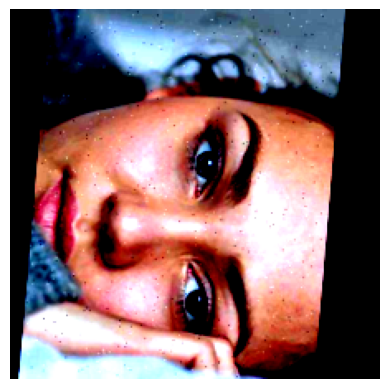

In [9]:
import matplotlib.pyplot as plt
import math

# Select one image from your DataFrame
img_tensor = df["images"].iloc[1]

# Convert tensor to a numpy array for visualization
img_tensor = img_tensor.permute(1, 2, 0).numpy()  # Change dimension order for plotting

# Visualize the normalized image
plt.imshow(img_tensor)
plt.axis('off')  # Hide axis
plt.show()


In [10]:
train_data_dir ='/content/drive/MyDrive/SkincareProject/Oily-Dry-Skin-Types/train'
test_data_dir = '/content/drive/MyDrive/SkincareProject/Oily-Dry-Skin-Types/test'

In [11]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:
# Count occurrences of each label
label_counts = df['labels'].value_counts()
print(label_counts)
# Total number of samples
total_samples = len(df)

# Calculate class weights as the inverse of the frequency of each class
class_weights = {label: total_samples / count for label, count in label_counts.items()}

# Print the class weights
print(class_weights)


labels
1    1274
2    1120
0     758
Name: count, dtype: int64
{1: 2.4740973312401886, 2: 2.8142857142857145, 0: 4.158311345646438}


In [13]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

     # Unfreeze the last two layers
    for param in list(model.parameters())[-10:]:
        param.requires_grad = True  # Fine-tune last few layers

    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 3),

    )
    class_weights = torch.tensor([2.474, 2.814, 4.158], device=device)  # Adjust these based on class distribution
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [14]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224).to(device))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [15]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [16]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    predicted_class = prediction.argmax(dim=1)
    is_correct = predicted_class == y
    return is_correct.cpu().numpy().tolist()

In [17]:
from torch.utils.data import DataLoader, Dataset

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class to handle the DataFrame
class MyDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Extract the image data and label (assuming 'image_array' and 'label' columns)
        image = self.df.iloc[idx]['images']
        label = torch.tensor(self.df.iloc[idx]['labels'], dtype=torch.long)  # Adjust dtype if necessary
        return image, label

def get_data(df):
    train_rows = int(len(df)*0.6)
    train_df = df.iloc[:train_rows]

    val_rows = int(len(df)*0.1)
    val_df = df.iloc[train_rows:train_rows+val_rows]

    # Create datasets using the custom dataset class
    train_dataset = MyDataset(train_df)
    val_dataset = MyDataset(val_df)

    # Create DataLoaders from the datasets
    trn_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
    val_dl = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)

    return trn_dl, val_dl


In [19]:
trn_dl, val_dl = get_data(df)
model, loss_fn, optimizer = get_model()

In [20]:
import numpy as np

# Initialize lists to store losses and accuracies
train_losses, train_accuracies = [], []
val_accuracies = []

print("All losses and accuracies are for each epoch")
for epoch in range(10):
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    # Combine loss and accuracy calculation for training in a single loop
    model.train()  # Set the model to training mode
    for ix, batch in enumerate(trn_dl):
        x, y = batch

        # Move the data to the correct device (CPU/GPU)
        x, y = x.to(device), y.to(device)

        # Training batch: calculate loss and backpropagate
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)  # Custom function to train a batch
        train_epoch_losses.append(batch_loss)  # Convert loss to scalar and append

        # Calculate accuracy on the same batch
        is_correct = accuracy(x, y, model)  # Custom function to compute accuracy
        train_epoch_accuracies.extend(is_correct)


    # Calculate mean loss and accuracy for the training epoch
    train_epoch_loss = np.mean(train_epoch_losses)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    # Calculate validation accuracy
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients during validation
        for ix, batch in enumerate(val_dl):
            x, y = batch
            x, y = x.to(device), y.to(device)

            # Calculate validation accuracy
            val_is_correct = accuracy(x, y, model)
            val_epoch_accuracies.extend(val_is_correct)

    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    # Print metrics for the current epoch
    print(f"Epoch {epoch + 1}/30, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

    # Store the results for plotting or analysis later
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)


All losses and accuracies are for each epoch
Epoch 1/30, Training Loss: 0.8432, Training Accuracy: 0.6478, Validation Accuracy: 0.0000
Epoch 2/30, Training Loss: 0.5044, Training Accuracy: 0.8475, Validation Accuracy: 0.1285
Epoch 3/30, Training Loss: 0.2278, Training Accuracy: 0.9709, Validation Accuracy: 0.1840
Epoch 4/30, Training Loss: 0.1441, Training Accuracy: 0.9751, Validation Accuracy: 0.4826
Epoch 5/30, Training Loss: 0.0893, Training Accuracy: 0.9905, Validation Accuracy: 0.3299
Epoch 6/30, Training Loss: 0.0791, Training Accuracy: 0.9921, Validation Accuracy: 0.3646
Epoch 7/30, Training Loss: 0.0768, Training Accuracy: 0.9947, Validation Accuracy: 0.3646
Epoch 8/30, Training Loss: 0.0516, Training Accuracy: 0.9931, Validation Accuracy: 0.4062
Epoch 9/30, Training Loss: 0.0734, Training Accuracy: 0.9936, Validation Accuracy: 0.3646
Epoch 10/30, Training Loss: 0.0622, Training Accuracy: 0.9963, Validation Accuracy: 0.3819


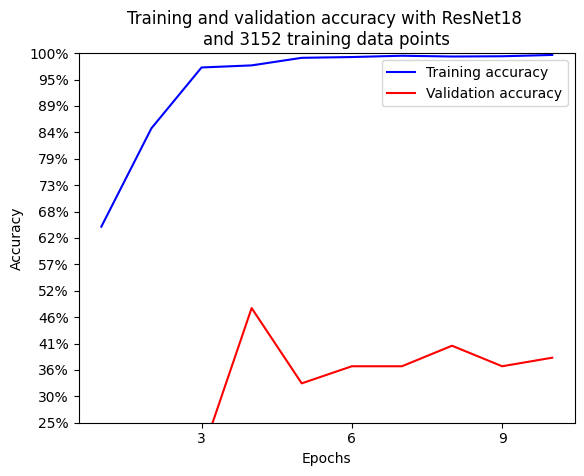

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Define the epochs and accuracy lists
epochs = np.arange(10) + 1  # Epoch numbers

# Plot the data
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')

# Set up the x-axis to show each epoch
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(3))

# Set title and labels
plt.title('Training and validation accuracy with ResNet18 \nand 3152 training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Adjust y-axis limits and format as percentages
plt.ylim(0.25, 1)
plt.gca().set_yticks(np.linspace(0.25, 1, 15))  # Set the ticks explicitly
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

# Add legend and grid
plt.legend()
plt.grid(False)  # Turn off the grid

# Show the plot
plt.show()
